# <center>Прогноз просрочки кредита заемщиком</center>
<center> Автор: Денис Сенькин

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve, learning_curve
RANDOM_STATE = 17

### Описание набора данных

Данные представляют собой исторические данные по 251503 заемщикам (https://www.kaggle.com/c/GiveMeSomeCredit). Задача является бинарной классификацией. Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу. Выборка разделена на тренировочную и тестовую ( 150000 в тренировочной части, 101503 в тестовой).

Данная решаемая задача будет ценна как кредиторам, так и заемщикам для оценки способности вернуть долг вовремя.

### Описание признаков

* 1 - __SeriousDlqin2yrs__ - будет ли просрочка более 90 дней в ближайшие 2 года (целевая метка) (Да/Нет)
* 2 - __RevolvingUtilizationOfUnsecuredLines__ - общий баланс по кредитным картам и кредитным линиям, за исключением задолженностей по недвижимости задолженности по взносам, деленные на сумму кредитных лимитов (проценты)
* 3 - __age__ - Возраст заемщика (в годах)
* 4 - __NumberOfTime30-59DaysPastDueNotWorse__ - количество просрочек в 30-59 дней (Целое)
* 5 - __DebtRatio__ - коэффициент задолженности, т.е. сумма ежемесячных платежей по долгам, алиментов и расходов на проживание, деленная на месячный доналоговый доход (проценты)
* 6 - __Monthly Income__ - месячный доход (число с плавающей точкой)
* 7 - __NumberOfOpenCreditLinesAndLoans__ - количество открытых кредитов и кредитных линий (Целое)
* 8 - __NumberOfTimes90DaysLate__ - количество просрочек более 90 дней (Целое)
* 9 - __NumberRealEstateLoansOrLines__ - количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии домашнего капитала (Целое)
* 10 - __NumberOfTime60-89DaysPastDueNotWorse__ - количество просрочек в 60-89 дней за последние 2 года (Целое)
* 11 - __NumberOfDependents__ - количество иждивенцев в семье (исключая самих заемщиков) (Целое)

In [2]:
def make_submission(predictions, fname):
    out = pd.DataFrame(data=predictions, columns=['Probability'])
    out.index += 1
    out.to_csv(fname, index_label='id')

In [3]:
df = pd.read_csv('../../data/credit/cs-training.csv', index_col=0)

In [4]:
feature_names = df.columns[1:]
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
print(df.shape)
df.describe(include = "all").T

(150000, 11)


,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [6]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [7]:
df.nunique()

SeriousDlqin2yrs                             2
RevolvingUtilizationOfUnsecuredLines    125728
age                                         86
NumberOfTime30-59DaysPastDueNotWorse        16
DebtRatio                               114194
MonthlyIncome                            13594
NumberOfOpenCreditLinesAndLoans             58
NumberOfTimes90DaysLate                     19
NumberRealEstateLoansOrLines                28
NumberOfTime60-89DaysPastDueNotWorse        13
NumberOfDependents                          13
dtype: int64

Как видно из описания, категориальные признаки отсутствуют.

Проверим на наличие NaN

In [8]:
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [9]:
(df['MonthlyIncome'].isnull() & df['NumberOfDependents'].isnull()).sum()

3924

По всей видимости, часть заемщиков отказалась разглашать информацию о своих доходах а также о членах семьи. 
Для месячного дохода заменим NaN на среднее значение по выборке, для количества иждивенцев - на 0

In [10]:
df['MonthlyIncome'].fillna(df['MonthlyIncome'].mean(), inplace=True)
df['NumberOfDependents'].fillna(0, inplace=True)

In [11]:
df['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [12]:
df.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

Т.о., классы не равны по размеру, количество заемщиков, сильно просрочивших возврат кредита значительно меньше, чем вовремя вернувших его.

__Визуализация данные__

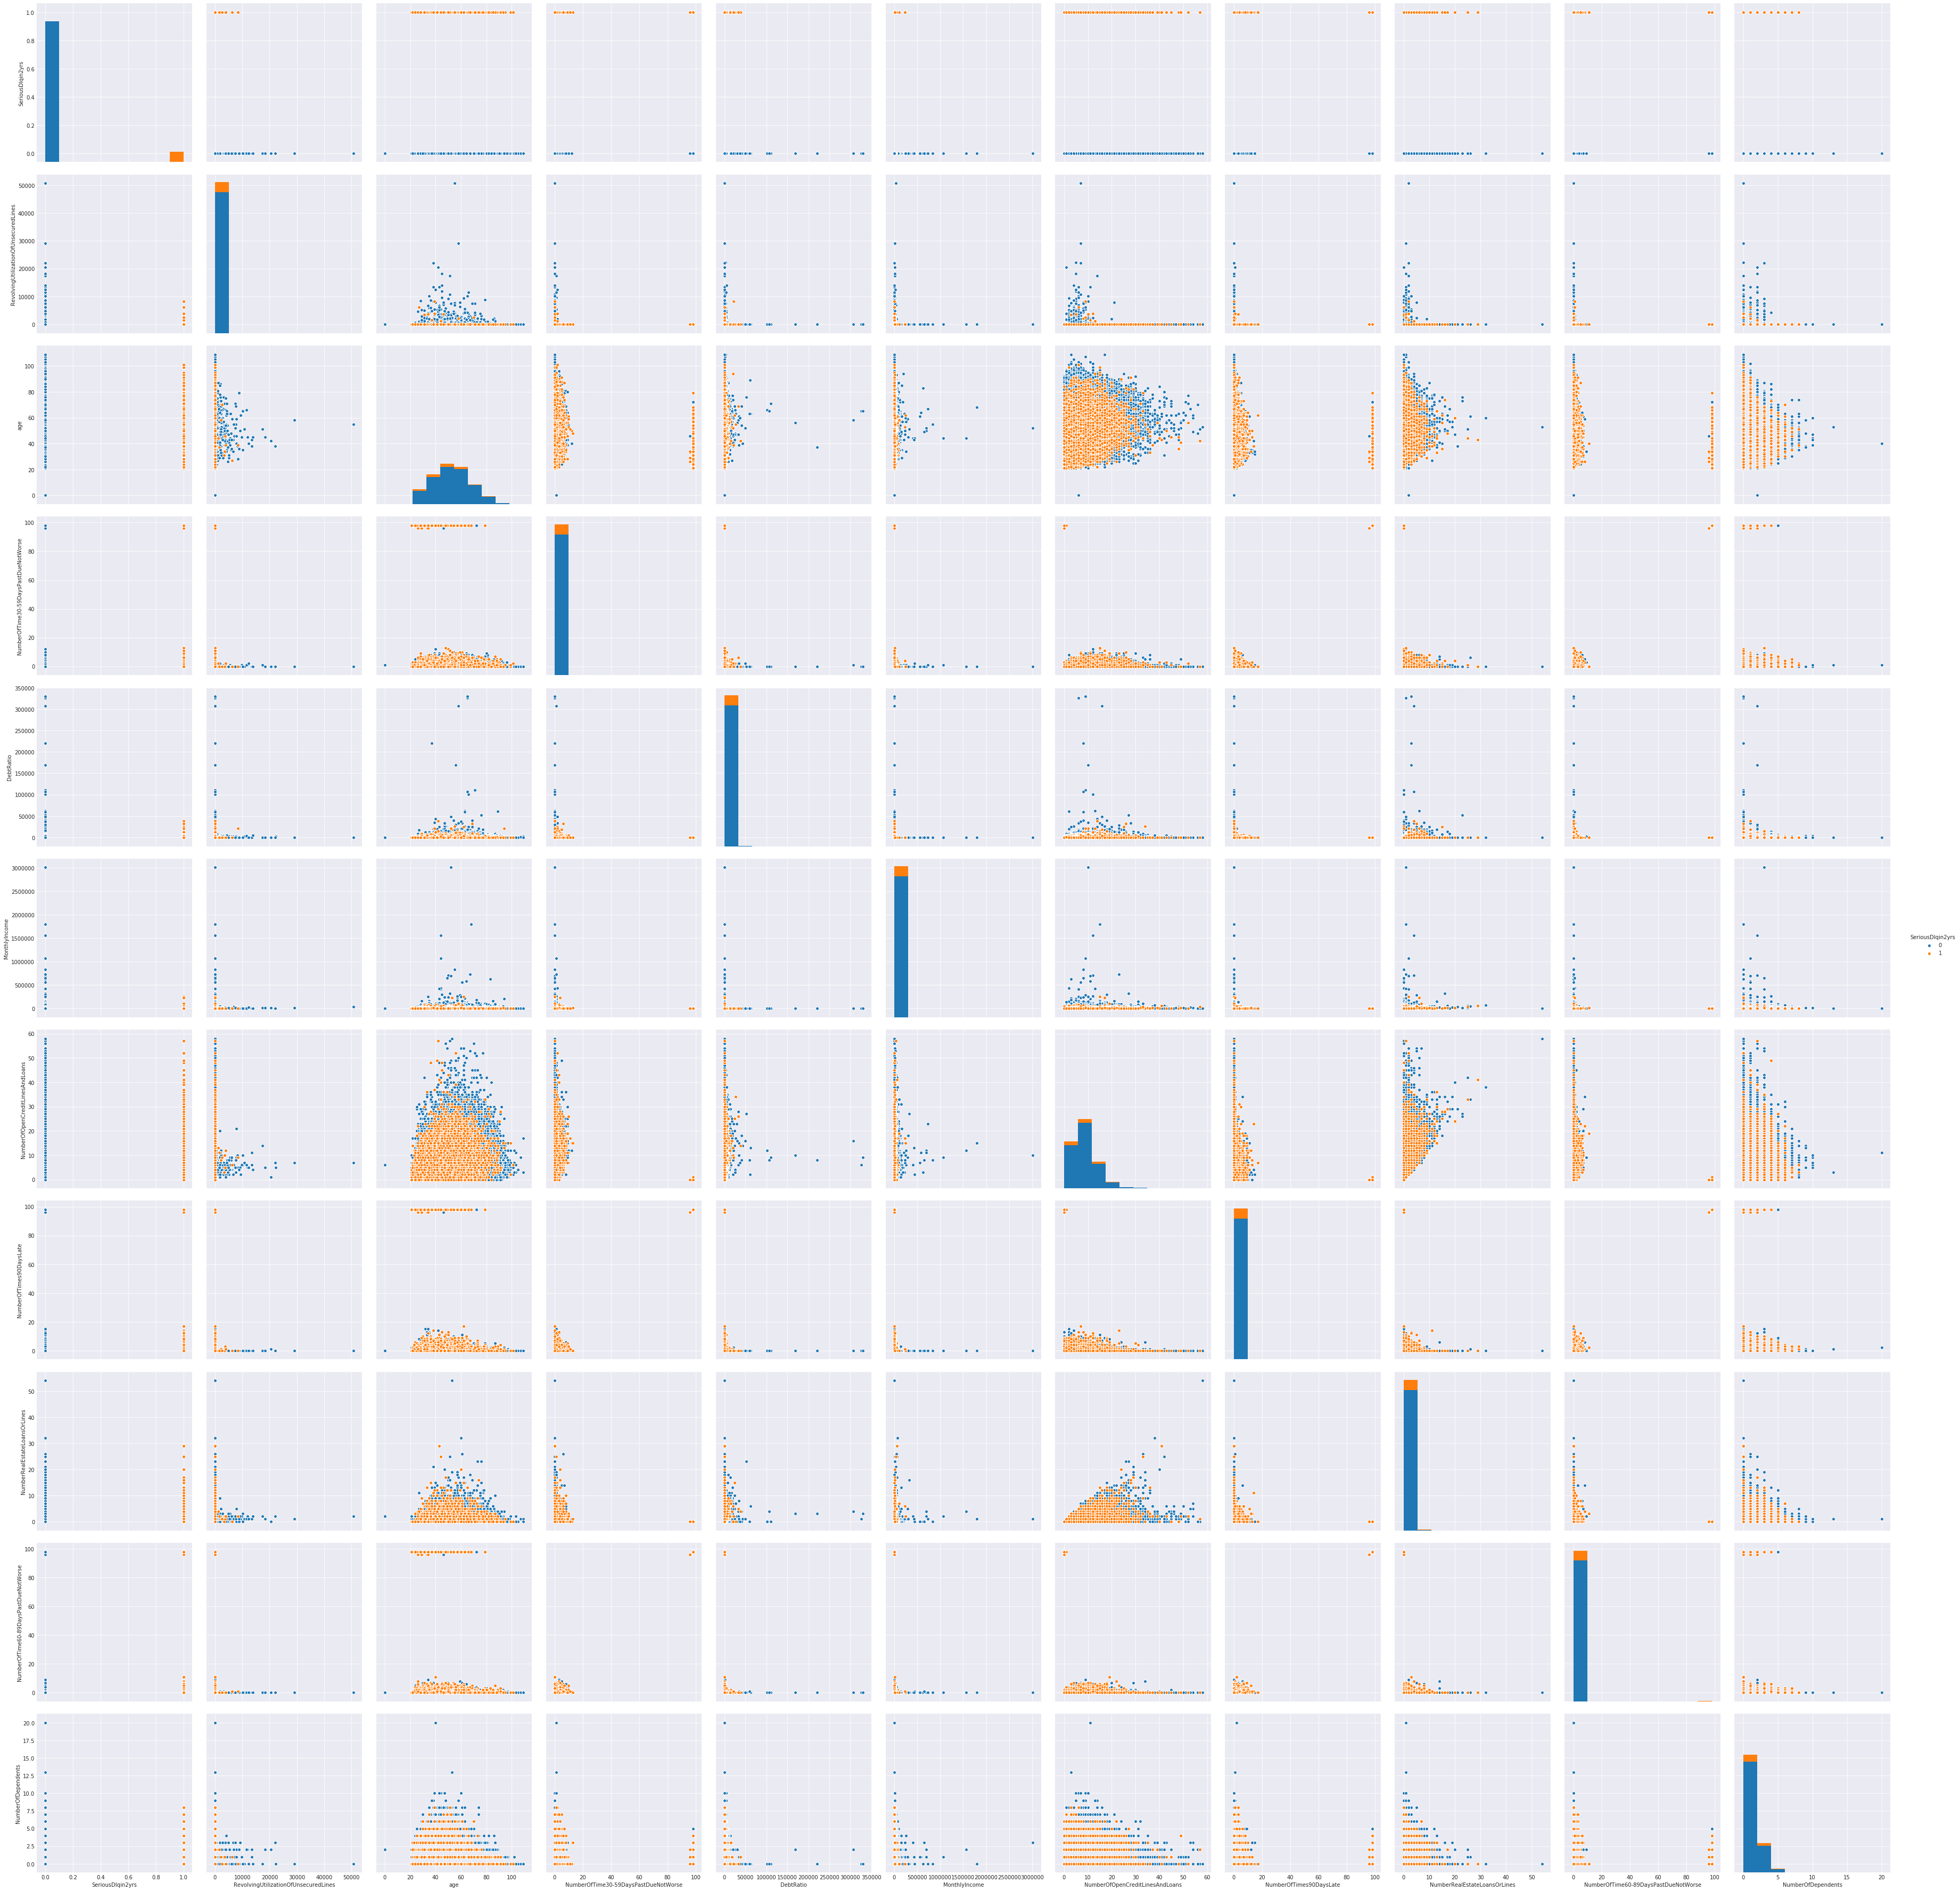

In [13]:
sns.pairplot(df, hue='SeriousDlqin2yrs', size=4.5);

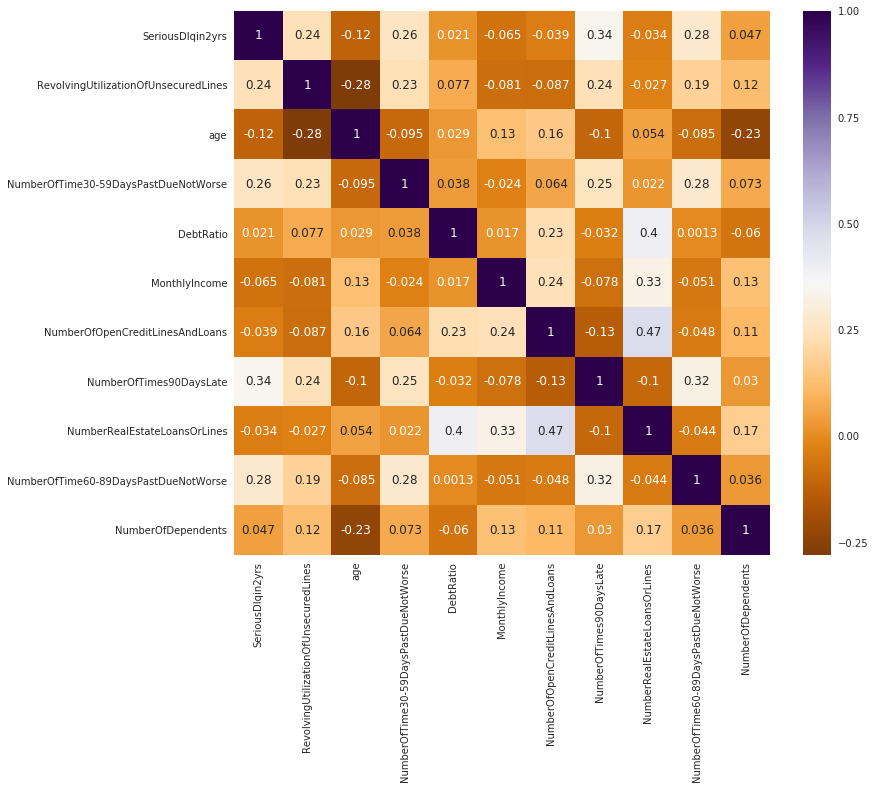

In [14]:
sns.set()
fig, ax = plt.subplots(figsize=(12,10));
sns.heatmap(df.corr('spearman'), cmap='PuOr', annot=True, ax=ax);

### <center>Закономерности:</center>

* Возраст заемщиков вне зависимости от значения целевой метки имеет распрделение, близкое к нормальному.
* Количество открытых кредитов коррелирует с количеством кредитов на недвижимость, что можно объяснить общей активностью заемщика.
* Целевая переменная зависит от количества предыдущих просрочек, чем больше по длительности была каждая просрочка, тем больше вероятность будущей. 

__Предобработка данных__

In [15]:
X_train = df.drop(columns=['SeriousDlqin2yrs'])
y_train = df['SeriousDlqin2yrs']

df_test = pd.read_csv('../../data/credit/cs-test.csv', index_col=0)
df_test['MonthlyIncome'].fillna(df_test['MonthlyIncome'].mean(), inplace=True)
df_test['NumberOfDependents'].fillna(0, inplace=True)

X_test = df_test.drop(columns=['SeriousDlqin2yrs'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

__Выбор метрики__

В качестве метрики используется ROC-AUC score, согласно соренованию. Данная метрика подходит для данной задачи, так как мы хотим определять тех заемщиков, которые сильно задержат выплату кредита, но при этом выдавать кредиты хорошим клиентам. Также эта метрика хорошо работает со случаем несбалансированных классов (как в нашем случае).

Для валидации был выбран метод Stratified KFold (т.к. выборка не сбалансирована) на 5 фолдов.

In [16]:
from sklearn.model_selection import cross_val_score

Обучим 2 классификатора - логистическую регрессию и случайный лес.
Сначала посмотрим на результаты при дефолтных параметрах.

In [17]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
logit = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', verbose=0)
forest = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=RANDOM_STATE, verbose=0)

scores = []

classifiers = [logit, forest]
for c in tqdm(classifiers, total=len(classifiers)):
    scores.append(cross_val_score(c, X_train_scaled, y_train, scoring='roc_auc', cv=kfold,n_jobs=-1, verbose=1))

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.8s finished


In [18]:
np.mean(scores, axis=1)

array([0.69848812, 0.8322709 ])

__Кросс-валидация и подбор параметров__

Произведем подбор параметров. Для логистической регрессии подберем коэффициент регуляризции, для случайного леса -максимальную глубину и максимальное кол-во признаков.

In [19]:
%%time
logit_params = {'C': np.logspace(0, 2, 7)}
forest_params = {'min_samples_leaf':[1, 3, 5, 7],
                 'max_depth': [None] + list(range(5, 15))}

logit_grid = GridSearchCV(logit, logit_params, scoring='roc_auc', n_jobs=-1,cv=kfold, verbose=1)
forest_grid = GridSearchCV(forest, forest_params, scoring='roc_auc', n_jobs=-1,cv=kfold, verbose=1)

scores_grid = []

classifiers_grid = [logit_grid, forest_grid]
for c in tqdm(classifiers_grid, total=len(classifiers_grid)):
    c.fit(X_train_scaled, y_train)
    scores_grid.append(c.best_score_)

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   31.2s finished


Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed: 12.6min finished



CPU times: user 29.7 s, sys: 3.91 s, total: 33.6 s
Wall time: 13min 16s


In [20]:
print(scores_grid)

[0.6984881896655569, 0.8646274182026982]


Лучший результат дал случайный лес. Выведем подобранные параметры.

In [21]:
forest_grid.best_params_

{'max_depth': 11, 'min_samples_leaf': 7}

In [22]:
predictions = forest_grid.predict_proba(X_test_scaled)[:, 1]
make_submission(predictions, 'sub1.csv')

Данная модель дает результат 0.860890 на public leaderboard и 0.864706 на private.

__Создание новых признаков__

Разделим заемщиков на 2 группы по возрасту (до и старше 18). Также создадим признак если ли иждевенцы у заемщика, количество возобновляемых кредитный линий (разность между общим кол-вом линий и заемов и количеством кредитов на недвижимость) и отношение кол-ва возобновляемых линий к кол-ву кредитов на недвижимость - данный признак показывает какой тип кредитов чаще берет заемщик.

In [23]:
df_features_train = pd.DataFrame(index=df.index)
df_features_train['age<18'] = df['age'].apply(lambda x: 1 if x < 18 else 0)

df_features_train['AgeDep'] = df['age'] / df['NumberOfDependents']
df_features_train['AgeDep'][df['NumberOfDependents'] == 0] = 0

df_features_train['NoDependents'] = (df['NumberOfDependents'] == 0)
df_features_train['RevolvLines'] = df['NumberOfOpenCreditLinesAndLoans'].values - df['NumberRealEstateLoansOrLines'].values
df_features_train['Rev2Estate'] = df_features_train['RevolvLines'] / (1 + df['NumberRealEstateLoansOrLines']) 

df_features_test = pd.DataFrame(index = df_test.index)
df_features_test['age<18'] = df_test['age'].apply(lambda x: 1 if x < 18 else 0)

df_features_test['AgeDep'] = df_test['age'] / df_test['NumberOfDependents']
df_features_test['AgeDep'][df_test['NumberOfDependents'] == 0] = 0

df_features_test['NoDependents'] = (df_test['NumberOfDependents'] == 0)
df_features_test['RevolvLines'] = df_test['NumberOfOpenCreditLinesAndLoans'].values - df_test['NumberRealEstateLoansOrLines'].values
df_features_test['Rev2Estate'] = df_features_test['RevolvLines'] / (1 + df_test['NumberRealEstateLoansOrLines']) 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [24]:
X_train_feat = pd.concat([X_train, df_features_train], axis=1)
X_test_feat = pd.concat([X_test, df_features_test], axis=1)

scaler = StandardScaler()
X_train_feat_scaled = scaler.fit_transform(X_train_feat)
X_test_feat_scaled = scaler.transform(X_test_feat)

In [25]:
%%time
forest_best = forest_grid.best_estimator_
result_feat = cross_val_score(forest_best, X_train_feat_scaled, y_train, cv=kfold, scoring='roc_auc',n_jobs=-1)

CPU times: user 430 ms, sys: 120 ms, total: 550 ms
Wall time: 18.5 s


In [26]:
print(np.mean(result_feat))

0.8639875793721536


In [27]:
forest_best.fit(X_train_feat_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [28]:
predictions = forest_best.predict_proba(X_test_feat_scaled)[:, 1]

In [29]:
make_submission(predictions, 'sub2.csv')

После создания новых признаков улучшился результат на private:
    0.860624 - на public;
    0.866692 - на private.

__Кривые валидации и обучения__

In [30]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5, random_state=17):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes=train_sizes, cv=cv,
                                                  scoring=scoring, random_state=random_state, n_jobs=-1)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

def plot_validation_curve(clf, X, y, cv_param_name, 
                          cv_param_values, scoring, cv=5, random_state=17):

    val_train, val_test = validation_curve(clf, X, y, cv_param_name,
                                           cv_param_values, cv=cv,
                                                  scoring=scoring, n_jobs=-1)
    plot_with_std(cv_param_values, val_train, 
                  label='training scores', c='green')
    plot_with_std(cv_param_values, val_test, 
                  label='validation scores', c='red')
    plt.xlabel(cv_param_name); plt.ylabel(scoring)
    plt.legend()

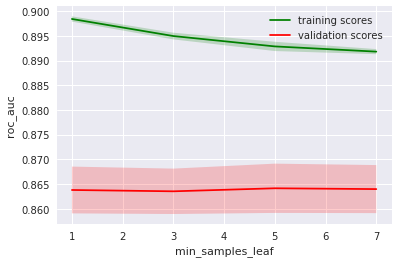

In [31]:
plot_validation_curve(forest_best, X_train_feat_scaled, y_train, 'min_samples_leaf', [1, 3, 5, 7], scoring='roc_auc', cv=kfold, random_state=RANDOM_STATE);

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


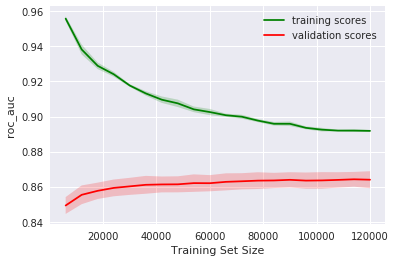

In [32]:
plot_learning_curve(forest_best, X_train_feat_scaled, y_train, scoring='roc_auc', cv=kfold)

__Оценка модели с описанием выбранной метрики__

Построена модель предсказания, предсказывающая просрочит ли заемщик выплату кредита на более чем 90 дней. В качестве целевой метрики была выбрана ROC-AUC score, позволяющая хорошо оценивать предсказания при сильно несбалансированной выборке. Построенная модель. Результат работы модели  $ROC-AUC \approx 0.86$.

Построены кривые обучения и валидационные кривые. Согласно ним, увеличение числа примеров больше 1000000 не дает существенного прироста в качестве.

__Общие выводы__

По результатам проведенного анализа, можно увидеть, что есть определенные зависимости и признаки просрочки кредита. 
Наблюдаются определенные закономерности - месячный доход, возраст заемщика.

Имеет влияние количество и длительность предыдущих просрочек - с ростом их числа, заемщик становиться менее привлекательным в связи с высокой вероятностью новой просрочки.

Также влияет и количество иждевенцев у заемщика - клиент с семьей реже не выплачивает кредит вовремя. 

В дальнейшем, можно добавить новые признаки (логарифмическая зависимость и т.д.)
Также можно заменить случайный лес на градиентый бустинг.